In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, Add, Dot, Conv2DTranspose, Activation, Reshape, LeakyReLU, Flatten, BatchNormalization
from SpectralNormalizationKeras import DenseSN, ConvSN2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.utils.generic_utils import Progbar
from time import time

/home/mathlab115/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# for resist GPU memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [3]:
#load Data
from keras.datasets import cifar100, cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
X = np.concatenate((x_test,x_train))
X.shape

(60000, 32, 32, 3)

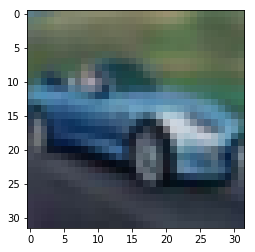

In [6]:
plt.imshow(X[9487])

In [7]:
#Hyperperemeter
BATCHSIZE=64
LEARNING_RATE = 0.0002
TRAINING_RATIO = 1
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.1
BN_EPSILON  = 0.00002
SAVE_DIR = 'img/generated_img_CIFAR10_DCGAN/'

GENERATE_ROW_NUM = 8
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

In [8]:
def BuildGenerator(summary=True):
    model = Sequential()
    model.add(Dense(4*4*512, kernel_initializer='glorot_uniform' , input_dim=128))
    model.add(Reshape((4,4,512)))
    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2DTranspose(64,  kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2DTranspose(3,   kernel_size=3, strides=1, padding='same', activation='tanh'))
    if summary:
        print("Generator")
        model.summary()
    return model

In [9]:
def BuildDiscriminator(summary=True, spectral_normalization=True):
    if spectral_normalization:
        model = Sequential()
        model.add(ConvSN2D(64, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same', input_shape=(32,32,3) ))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(64, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(128, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(128, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(256, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(256, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(ConvSN2D(512, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Flatten())
        model.add(DenseSN(1,kernel_initializer='glorot_uniform'))
    else:
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same', input_shape=(32,32,3) ))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(64, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(128, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(128, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(256, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(256, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Conv2D(512, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
        model.add(LeakyReLU(0.1))
        model.add(Flatten())
        model.add(Dense(1,kernel_initializer='glorot_uniform'))
    if summary:
        print('Discriminator')
        print('Spectral Normalization: {}'.format(spectral_normalization))
        model.summary()
    return model

In [10]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

In [11]:
generator = BuildGenerator()
discriminator = BuildDiscriminator()

Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        131136    


In [12]:
Noise_input_for_training_generator = Input(shape=(128,))
Generated_image                    = generator(Noise_input_for_training_generator)
Discriminator_output               = discriminator(Generated_image)
model_for_training_generator       = Model(Noise_input_for_training_generator, Discriminator_output)
print("model_for_training_generator")
model_for_training_generator.summary()

model_for_training_generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         3813251   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 2935873   
Total params: 6,749,124
Trainable params: 6,748,228
Non-trainable params: 896
_________________________________________________________________


In [13]:
discriminator.trainable = False
model_for_training_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         3813251   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 2935873   
Total params: 6,749,124
Trainable params: 3,812,355
Non-trainable params: 2,936,769
_________________________________________________________________


In [14]:
model_for_training_generator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss=wasserstein_loss)

In [15]:
Real_image                             = Input(shape=(32,32,3))
Noise_input_for_training_discriminator = Input(shape=(128,))
Fake_image                             = generator(Noise_input_for_training_discriminator)
Discriminator_output_for_real          = discriminator(Real_image)
Discriminator_output_for_fake          = discriminator(Fake_image)

model_for_training_discriminator       = Model([Real_image,
                                                Noise_input_for_training_discriminator],
                                               [Discriminator_output_for_real,
                                                Discriminator_output_for_fake])
print("model_for_training_discriminator")
generator.trainable = False
discriminator.trainable = True
model_for_training_discriminator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss=[wasserstein_loss, wasserstein_loss])
model_for_training_discriminator.summary()

model_for_training_discriminator
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 128)           0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 32, 32, 3)     3813251     input_3[0][0]                    
____________________________________________________________________________________________________
sequential_2 (Sequential)        (None, 1)             2935873     input_2[0][0]                    
                                                          

In [16]:
real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = -real_y

In [17]:
X = X/255*2-1

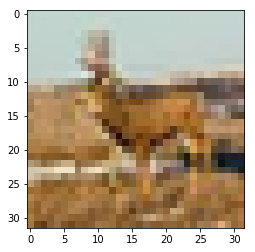

In [18]:
plt.imshow((X[8787]+1)/2)

In [19]:
test_noise = np.random.randn(GENERATE_BATCHSIZE, 128)
W_loss = []
discriminator_loss = []
generator_loss = []
for epoch in range(EPOCHS):
    np.random.shuffle(X)
    
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO)))
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    
    start_time = time()
    for index in range(int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        discriminator_minibatches = X[index * minibatches_size:(index + 1) * minibatches_size]
        
        for j in range(TRAINING_RATIO):
            image_batch = discriminator_minibatches[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
            discriminator.trainable = True
            generator.trainable = False
            discriminator_loss.append(model_for_training_discriminator.train_on_batch([image_batch, noise],
                                                                                      [real_y, fake_y]))
        discriminator.trainable = False
        generator.trainable = True
        generator_loss.append(model_for_training_generator.train_on_batch(np.random.randn(BATCHSIZE, 128), real_y))
    
    print('\nepoch time: {}'.format(time()-start_time))
    
    W_real = model_for_training_generator.evaluate(test_noise, real_y)
    print(W_real)
    W_fake = model_for_training_generator.evaluate(test_noise, fake_y)
    print(W_fake)
    W_l = W_real+W_fake
    print('wasserstein_loss: {}'.format(W_l))
    W_loss.append(W_l)
    #Generate image
    generated_image = generator.predict(test_noise)
    generated_image = (generated_image+1)/2
    for i in range(GENERATE_ROW_NUM):
        new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(32*GENERATE_ROW_NUM,32,3)
        if i!=0:
            old = np.concatenate((old,new),axis=1)
        else:
            old = new
    print('plot generated_image')
    plt.imsave('{}/SN_epoch_{}.png'.format(SAVE_DIR, epoch), old)

epoch 1 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 65.86544990539551
32/64 [==============>...............] - ETA: 0s-570.5798645019531
wasserstein_loss: 9.1552734375e-05
plot generated_image
epoch 2 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.417253255844116
32/64 [==============>...............] - ETA: 0s1419.6845703125
wasserstein_loss: 0.0001220703125
plot generated_image
epoch 3 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.60102653503418
32/64 [==============>...............] - ETA: 0s20.736845016479492
wasserstein_loss: 3.814697265625e-06
plot generated_image
epoch 4 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 63.488672494888306
32/64 [==============>...............] - ETA: 0s467.9406433105469
wasserstein_loss: 9.1552734375e-05
plot generated_image
epoch 5 of 500
number of batches:

KeyboardInterrupt: 

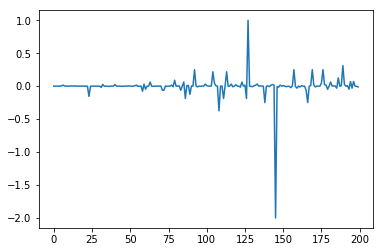

In [21]:
plt.plot(W_loss)

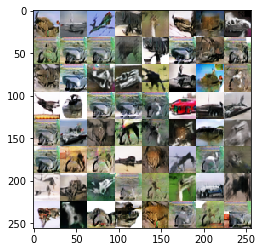

In [25]:
plt.imshow(old)